In [1]:
import requests
import re
from bs4 import BeautifulSoup
from urllib.request import urlopen
import os
import seaborn as sns
import charts_function_list, viz_functions
from functools import reduce
_,data,outputs = charts_function_list.folder_setup()

### Frame to pull data fields for pro football reference

In [10]:
def main_pull(url,type_ = str):
    index_list = []
    url_list = []
    #set counter
    count = 0
    #
    url = url
    html = urlopen(url) #get_request
    soup = BeautifulSoup(html,"lxml")
    #pull the URL from the Pro Football Reference page you specify
    #returns the URL and something to index on
    for tr in soup.select('tbody'):
        for th in tr.find_all('th'):
            for a in th.find_all('a',href=True):
                try:
                    index_list.append(type_(a.get_text()))
                    url_list.append(base+a['href'])
   
                except:
                    pass
                    count-=1
                
                count+=1
                
                
    return count,index_list,url_list


base = 'https://www.pro-football-reference.com'

#create list of current teams and the URL to their page
teams,urls = main_pull(url='https://www.pro-football-reference.com/teams/')[1:]

#pull seasons and season url, create count of seasons
season_count = []
for urls_ in urls:
    counts,season,season_url = main_pull(type_=int,url=urls_)
    season_count.append(counts)
    
#match the list to 
full_teams = [v for item,v in enumerate(teams) for x in range(season_count[item])]



stadium = []
stadium_url = []


for url in season_url:
    url = url
    html = urlopen(url) #get_request
    soup = BeautifulSoup(html,"lxml")
    
    texts = []

    for tr in soup.select('p'):
        for strong in tr.find_all('strong'):
            texts.append(strong.get_text())
            
    if (True in pd.Series(texts).isin(['Stadium:']).unique()) is False:
                stadium_url.append('')
                stadium.append('')
    else:


        for tr in soup.select('p'):
            for strong in tr.find_all('strong'):
                if strong.get_text()=='Stadium:':
                    for a in tr.find_all('a'):
                        stadium_url.append((a['href']))
                        stadium.append(a.get_text())
                else: 
                    pass

surface = []

for url in stadium_url:
    
    try:
        html = urlopen(url) #get_request
        soup = BeautifulSoup(html,"lxml")
        for tr in soup.select('p'):
            for bold in tr.find_all('b'):
                if bold.get_text()=='Surfaces:':
                    surface_text = (tr.get_text())
                    surface.append(surface_text.split(':')[1])                    
    except:
        surface.append('')
        pass
                
season_frame = pd.DataFrame({'Teams':full_teams,
                    'Season':season,
                    'Season URL':season_url,
                            'Stadium':stadium,
                            'Stadium_url':stadium_url,
                            'Surfaces':surface})

os.chdir(outputs)
season_frame.to_csv('season_frame_initial.csv')

### Load data full frame and fix some missing fields

In [1021]:
season_frame = pd.read_csv('season_frame_initial.csv',index_col=0).drop('Unnamed: 0.1',axis=1)
season_frame['Surface'] = season_frame['Surface'].fillna('-')
to_research = season_frame[season_frame['Stadium'].isnull()].copy()
locations = to_research.index

season_frame.loc[locations[0],['Stadium','Stadium_url','Surface']]=['Metropolitan Field/Soldier Field','https://www.pro-football-reference.com/stadiums/MIN99.htm','grass (1959-1981)']
season_frame.loc[locations[1:3],['Stadium','Stadium_url','Surface']]=['Normal Park','https://www.pro-football-reference.com/stadiums/CHI94.htm','grass (1920-1928)']
season_frame.loc[locations[3],['Stadium','Stadium_url','Surface']]=['Mercedes-Benz Stadium','https://www.pro-football-reference.com/stadiums/ATL97.htm','fieldturf (2017)']
season_frame.loc[locations[4],['Stadium','Stadium_url','Surface']]=['Staley Field/Cubs Fields','https://www.pro-football-reference.com/stadiums/CHI96.htm','grass (1920-1970)']
season_frame.loc[locations[5],['Stadium','Stadium_url','Surface']]=['Staley Field','https://www.pro-football-reference.com/stadiums/CHI93.htm','grass (1920)']
#Location not found on pro football reference but first noted on wikipedia, corroborated at https://www.mlb.com/tigers/history/ballparks
season_frame.loc[locations[6],['Stadium','Stadium_url','Surface']]=['University of Detroit Stadium','https://www.pro-football-reference.com/stadiums/DET97.htm','grass (1928-1940)']
season_frame.loc[locations[7],['Stadium','Stadium_url','Surface']]=['Hagemeister Park','https://www.pro-football-reference.com/stadiums/GNB97.htm','grass (1921-1922)']
season_frame.loc[locations[8],['Stadium','Stadium_url','Surface']]=['TCF Bank Stadium','https://www.pro-football-reference.com/stadiums/MIN98.htm','fieldturf (2010-2017)']
season_frame.loc[locations[9],['Stadium','Stadium_url','Surface']]=['Philadelphia Municipal Stadium','https://www.pro-football-reference.com/stadiums/PHI96.htm','grass (1931-1950)']
season_frame.loc[locations[10],['Stadium','Stadium_url','Surface']]=['Levi\'s Stadium','https://www.pro-football-reference.com/stadiums/SFO01.htm','grass (2014-2017)']

#two more known error
season_frame.loc[933,['Stadium','Stadium_url','Surface']]= ['StubHub Center','https://www.pro-football-reference.com/stadiums/LAX97.htm','grass (2017)']
season_frame.loc[1426,['Surface']]= 'grass (1964-1983)'

In [1022]:

def surface_appender(value):
    empty_list = []
    for item in season_frame['Surface'].str.split(","):
        
        #split each field summary and set as a list
        fields=item
        
        #try to append a certain length of the list to create a new array for later use
        try:
            empty_list.append(fields[value])
        #if it's not as long as the specified value, append nothingness
        except:
            empty_list.append(nan)
    return empty_list

season_frame = pd.merge(season_frame,pd.DataFrame({'Surface 1':surface_appender(0),
                     'Surface 2':surface_appender(1),
                     'Surface 3':surface_appender(2),
                     'Surface 4':surface_appender(3),
                     'Surface 5':surface_appender(4)}),left_index=True,right_index=True,how='left')

#function to split columns by - and () to get seasons
def column_split_strip(df,column):
    surface_split = df[column].str.split('-|\)|\(',expand=True).loc[:,0:2]
    surface_split[0]= surface_split[0].str.strip()
    surface_split.columns = [column,'Start_Year_'+column,'End_Year_'+column]
    surface_split = surface_split.replace({'':nan})
    surface_split['End_Year_'+column] = surface_split[['End_Year_'+column]].fillna(2018)
    surface_split[[column,'Start_Year_'+column]] = surface_split[[column,'Start_Year_'+column]].fillna(0)
    surface_split[['Start_Year_'+column,'End_Year_'+column]] = surface_split[['Start_Year_'+column,'End_Year_'+column]].astype('int')
    return surface_split

#pull full field set-up
full_fields = reduce(lambda x,y:pd.merge(left=x,right=y,
                          left_index=True, right_index=True,how='left'),
       [column_split_strip(season_frame,x) for x in ['Surface 1','Surface 2','Surface 3','Surface 4','Surface 5']])

season_frame = pd.merge(left=season_frame,right=full_fields,left_index=True,right_index=True,how='left').drop(['Surface 1_x',
                                                                                              'Surface 2_x','Surface 3_x',
                                                                                              'Surface 4_x',
                                                                                               'Surface 5_x'],axis=1)


#cleaning up fields with single year surfaces

season_frame.loc[(season_frame['End_Year_Surface 1']==2018)&(season_frame['Start_Year_Surface 2']!=0),
                 'End_Year_Surface 1'] =season_frame.loc[(season_frame['End_Year_Surface 1']==2018)&(season_frame['Start_Year_Surface 2']!=0),
                 'Start_Year_Surface 1']

season_frame.loc[(season_frame['End_Year_Surface 2']==2018)&(season_frame['Start_Year_Surface 3']!=0),
                 'End_Year_Surface 2'] =season_frame.loc[(season_frame['End_Year_Surface 2']==2018)&(season_frame['Start_Year_Surface 3']!=0),
                 'Start_Year_Surface 2']


season_frame.loc[(season_frame['End_Year_Surface 3']==2018)&(season_frame['Start_Year_Surface 4']!=0),
                 'End_Year_Surface 3'] =season_frame.loc[(season_frame['End_Year_Surface 3']==2018)&(season_frame['Start_Year_Surface 4']!=0),
                 'Start_Year_Surface 3']


season_frame.loc[(season_frame['End_Year_Surface 4']==2018)&(season_frame['Start_Year_Surface 5']!=0),
                 'End_Year_Surface 4'] =season_frame.loc[(season_frame['End_Year_Surface 4']==2018)&(season_frame['Start_Year_Surface 5']!=0),
                 'Start_Year_Surface 4']


def field_assignment(df):
    if (df['Season']>=df['Start_Year_Surface 1']) & (df['Season']<=df['End_Year_Surface 1']) & (df['Surface 1_y']!=0):
        return df['Surface 1_y']
    elif (df['Season']>=df['Start_Year_Surface 2']) & (df['Season']<=df['End_Year_Surface 2']) & (df['Surface 2_y']!=0):
            return df['Surface 2_y']
    elif (df['Season']>=df['Start_Year_Surface 3']) & (df['Season']<=df['End_Year_Surface 3'])& (df['Surface 3_y']!=0):
            return df['Surface 3_y']
    elif (df['Season']>=df['Start_Year_Surface 4']) & (df['Season']<=df['End_Year_Surface 4'])& (df['Surface 4_y']!=0):
            return df['Surface 4_y']
    elif (df['Season']>=df['Start_Year_Surface 5']) & (df['Season']<=df['End_Year_Surface 5'])& (df['Surface 5_y']!=0):
            return df['Surface 5_y']
    else:
        return 'error'
    
season_frame['Actual Surface'] = season_frame.apply(field_assignment,axis=1)

In [1057]:
season_frame = pd.concat([season_frame,pd.DataFrame({'Season':[1943,1944],
              'Stadium':['Mixed' for x in range(2)],
              'Teams':['Pittsburgh Steelers' for x in range(2)],
                      'Actual Surface':['grass' for x in range(2)]},index=[len(season_frame),len(season_frame)+1])])

In [1285]:
cleaned_season_frame = season_frame[['Season','Stadium','Teams','Actual Surface']].copy()
cleaned_season_frame.to_csv('clean_stadium_fields.csv')

### Visualizing the fields

In [1287]:
#create new index for ordering teams by length
teams_in_season_order = cleaned_season_frame.groupby('Teams').size().sort_values().index
cleaned_season_frame['Order'] = cleaned_season_frame['Teams'].map({v:i+1 for i,v in enumerate(teams_in_season_order)})
cleaned_season_frame.set_index(['Order'],inplace=True)
cleaned_season_frame['Actual Surface'] = cleaned_season_frame['Actual Surface'].apply(lambda x: (x[0]).upper()+x[1:])
cleaned_season_frame.replace({'Actual Surface':{'A_turf':'A-Turf'}},inplace=True)

### Create surface colors

In [1288]:
field_list = list(cleaned_season_frame['Actual Surface'].unique())


field_list.insert(1,field_list.pop(field_list.index('Dessograss')))
colors = ['#41ab5d','#a1d99b','#08306b','#08519c',
          '#2171b5','#4292c6','#6baed6',
          '#9ecae1','#c6dbef','#deebf7','#f7fbff']


field_map = {field_list[x]:colors[x] for x in range(len(colors))}
field_colors = cleaned_season_frame['Actual Surface'].map(field_map)

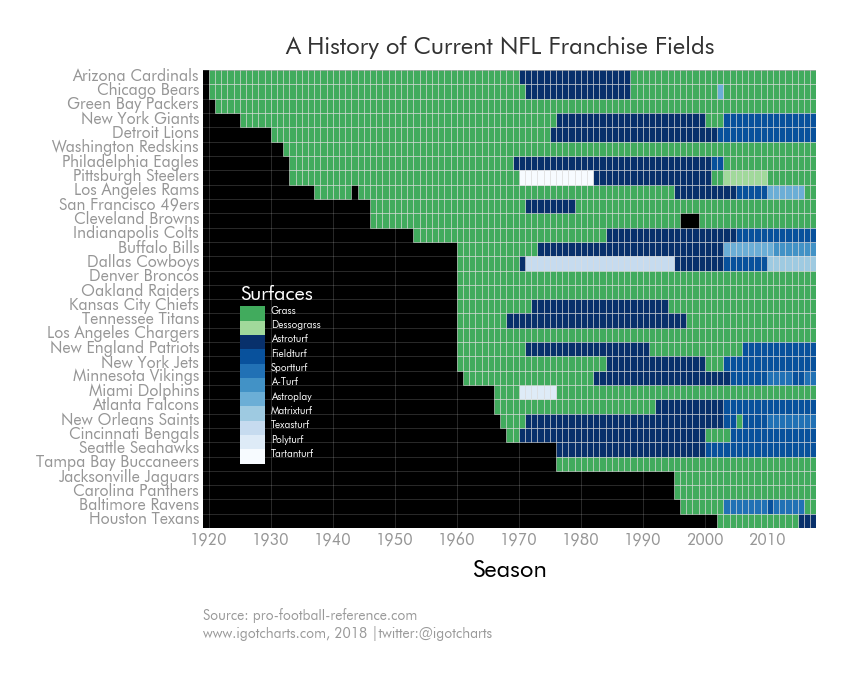

In [1294]:
field_chart = viz_functions.chart_maker('A History of Current NFL Franchise Fields',title_size=24)
fig  = field_chart.initial_fig_axis()
fig.subplots_adjust(top=.92)
ax = field_chart.axes_set_up(fig)

plt.barh(bottom=cleaned_season_frame.index-.5,width=[1 for x in range(1968)],height=1,
         left=cleaned_season_frame['Season'],color=field_colors,zorder=2,label='a',edgecolor='#f0f0f0',linewidth=.5)

field_chart.patch_adder(ax,facecolor='black')
field_chart.tick_params_(ax)
field_chart.y_axis_setup(ax,0,32)
field_chart.x_axis_setup(ax,1919,2018,10)
ax.set_yticklabels(teams_in_season_order.insert(0,''),va='bottom')

ax.text(1925,16,'Surfaces',fontsize=20,color='white',weight='bold',ha='left')
ax.grid(color='white',zorder=2,alpha=.2)
for i,v in enumerate(zip(field_map.keys(),field_map.values())):
    ax.text(1930,15-i,v[0],color='white')
    plt.barh(bottom=15-i,width=4,height=1,left=1925,zorder=2,color=v[1])

ax.set_xlabel('Season',fontsize=24)
    
field_chart.citations(ax,source='Source: pro-football-reference.com',
                      chart_tag='www.igotcharts.com, 2018 |twitter:@igotcharts',
                      source_y=-.2,chart_tag_y=-.24)

plt.show()

In [1010]:
#finding the max different surfaces on a single stadium
surface_counts = []

for item in season_frame['Surface'].str.split(','):
    surface_counts.append(len(item))
   
max_surfaces = np.max(surface_counts)

5